In [1]:
from keras import models
from keras import layers
from keras import optimizers, losses, metrics
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16

import numpy as np
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


<br>
<br>

# 데이터 로드 / 전처리

In [2]:
# 데이터셋 디렉터리 경로
dataset_dir = './dataset/caltech101'
train_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'validation')
test_dir = os.path.join(dataset_dir, 'test')

# 사진 크기
image_width = 100
image_height = 100

# ImageDataGenerator 초기화
# 0~1 사이로 숫자값 변경
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 훈련셋 제너레이터
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_width, image_height),
    batch_size=30,
    class_mode='categorical')

# 검증셋 제너레이터
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(image_width, image_height),
    batch_size=30,
    class_mode='categorical')

# 테스트셋 제너레이터
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_width, image_height),
    batch_size=30,
    class_mode='categorical')


Found 1800 images belonging to 10 classes.
Found 600 images belonging to 10 classes.
Found 600 images belonging to 10 classes.


<br>
<br>

# 모델 생성

In [3]:
# VGG16 모델 생성
base_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(image_width, image_height, 3))

# 모델 구조 요약
base_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [4]:
# 우선은 베이스 모델을 학습이 가능하도록 설정
base_model.trainable = True
trainable_flag = False

# 베이스 모델의 모든 층 반복
for layer in base_model.layers:
    # block5_conv1 이후 최상층 레이어만 학습이 되도록 설정
    if layer.name == 'block5_conv1':
        trainable_flag = True
        
    if trainable_flag:
        layer.trainable = True
    else:
        layer.trainable = False

특성 추출은 베이스 모델 전체가 학습이 안되게 고정합니다. 하지만 미세 조정(fine tuning)은 일부 레이어는 학습이 가능하도록 합니다. 이렇게 하면 완전연결층만 가중치를 조정하는 것보다 학습이 더 잘될 수 있습니다.
<br>
<br>
<br>

In [5]:
def build_model():
    
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer=optimizers.RMSprop(lr=1e-5), # 학습률 낮춤
                  loss='categorical_crossentropy',
                  metrics=['acc'])    
    
    return model

이전과 동일한 모델이지만 옵티마이저의 학습률을 0.00001로 낮게 설정했습니다. 학습률을 변경하기 위해서는 위와 같이 optimizers로 새로 생성을 해야 합니다.

미세 조정일 때는 이미 사전 훈련된 가중치를 급격하게 변동하지 않는게 좋습니다. 이전 기본 옵티마이저인 'rmsprop'의 디폴트 값은 0.001이었습니다.

<br>
<br>

# 훈련 및 평가

In [6]:
# 모델 생성
model = build_model()

# 훈련 시작
history = model.fit_generator(train_generator,
                              steps_per_epoch=60,
                              epochs=25,
                              validation_data=validation_generator,
                              validation_steps=20)


Epoch 1/25
60/60 [==============================] - 492s 8s/step - loss: 1.3570 - acc: 0.5783 - val_loss: 0.6404 - val_acc: 0.8017
Epoch 2/25
60/60 [==============================] - 473s 8s/step - loss: 0.5869 - acc: 0.8233 - val_loss: 0.2851 - val_acc: 0.9250
Epoch 3/25
60/60 [==============================] - 478s 8s/step - loss: 0.2940 - acc: 0.9206 - val_loss: 0.1676 - val_acc: 0.9583
Epoch 4/25
60/60 [==============================] - 571s 10s/step - loss: 0.1550 - acc: 0.9594 - val_loss: 0.1229 - val_acc: 0.9700
Epoch 5/25
60/60 [==============================] - 525s 9s/step - loss: 0.1012 - acc: 0.9733 - val_loss: 0.1049 - val_acc: 0.9700
Epoch 6/25
60/60 [==============================] - 531s 9s/step - loss: 0.0634 - acc: 0.9806 - val_loss: 0.0908 - val_acc: 0.9717
Epoch 7/25
60/60 [==============================] - 616s 10s/step - loss: 0.0469 - acc: 0.9850 - val_loss: 0.0702 - val_acc: 0.9850
Epoch 8/25
60/60 [==============================] - 607s 10s/step - loss: 0.0342 

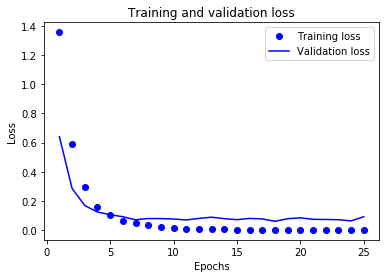

In [7]:
loss = history.history['loss']         # 훈련 손실
val_loss = history.history['val_loss'] # 검증 손실

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')      # bo -> 파란색 점
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b -> 파란색 실선
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


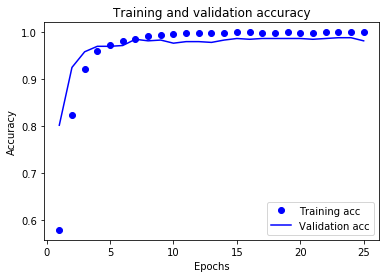

In [8]:
acc = history.history['acc']           # 훈련 정확도
val_acc = history.history['val_acc']   # 검증 정확도

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


검증 정확도가 최고 98.8% 나왔습니다. 베이스 모델의 가중치를 고정한 특성 추출에서는 98.0% 였습니다. 많이는 아니지만 성능이 조금 향상되었습니다.
<br>
<br>
<br>

In [9]:
# 모델 저장
model.save('./model/image_cnn_fine_tuning_model.h5')

<br>
<br>

# 테스트셋 확인

In [10]:
# 저장된 모델 파일 로드
model = models.load_model('./model/image_cnn_fine_tuning_model.h5')

In [11]:
# 테스트셋 평가
results = model.evaluate_generator(test_generator)
results


[0.06149363057843402, 0.989999994635582]

테스트셋의 정확도가 98.9% 입니다. 특성 추출에서의 96.8% 보다 2% 정도 올랐습니다.